# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_082  P42262;P42262-2;P42262-3   15.894
Sample_136  G3V2W1;Q9UK55              14.269
Sample_021  O60883                     19.752
Sample_032  P01036;P01037              15.831
Sample_195  P23471;P23471-2            19.361
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups          
Sample_110  Q7Z5L7;Q7Z5L7-2;Q7Z5L7-3   13.013
Sample_058  Q9C0C4                     13.659
Sample_171  P00915                     16.368
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.663
            A0A075B6Q5                 13.736
            A0A075B6R2                 12.809
            A0A075B6S5                 14.226
            A0A087WSY4                 11.432
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.578
            Q9UI40;Q9UI40-2            12.776
            Q9UIW2                     12.204
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.320
            Q9UP79                     11.536
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.761,15.050,16.842,19.863,15.722,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.790,19.067,...,15.528,15.576,14.046,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.697,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.263,17.705,17.039,16.115,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.489,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.592,15.345,17.084,18.708,14.249,19.433,12.034,11.066
Sample_207,15.739,16.877,15.469,16.898,15.688,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.663,...,16.012,15.178,11.659,15.050,16.842,19.863,14.026,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.242,19.067,16.188,...,15.528,15.576,12.502,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.811,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.999,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.790,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.507,15.345,17.084,18.708,14.249,19.433,13.489,11.846
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 419.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.95it/s]

100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.53it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.73it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.68it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.20it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.51it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.71it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.54it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.43it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.84it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.59it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.48it/s]

100%|██████████| 7/7 [00:01<00:00,  3.48it/s]

100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.92it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.47it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.87it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.66it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.52it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.38it/s]

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.39it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.15it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.80it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.52it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.50it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.37it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.36it/s]

100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.98it/s]

 30%|███       | 3/10 [00:00<00:01,  3.80it/s]

 40%|████      | 4/10 [00:01<00:01,  3.44it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.34it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.26it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.28it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.34it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.35it/s]

100%|██████████| 10/10 [00:02<00:00,  3.29it/s]

100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.81it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.46it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.19it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.03it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.08it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.06it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.19it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.46it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.63it/s]

100%|██████████| 11/11 [00:04<00:00,  2.82it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.84it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.38it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.02it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.03it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.19it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.24it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.27it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.29it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.84it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.48it/s]

100%|██████████| 12/12 [00:04<00:00,  2.34it/s]

100%|██████████| 12/12 [00:04<00:00,  2.86it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:04,  2.74it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.45it/s]

 31%|███       | 4/13 [00:01<00:04,  2.15it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.30it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.32it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.47it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.63it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.77it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.92it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.95it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.00it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.42it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.35it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.89it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.72it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.84it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.80it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.71it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.53it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.46it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.46it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.58it/s]

100%|██████████| 14/14 [00:05<00:00,  2.66it/s]

100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.46it/s]

 20%|██        | 3/15 [00:01<00:05,  2.30it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.20it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.11it/s]

 40%|████      | 6/15 [00:02<00:03,  2.38it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.49it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.61it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.75it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.84it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.88it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.98it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  3.01it/s]

100%|██████████| 15/15 [00:05<00:00,  3.10it/s]

100%|██████████| 15/15 [00:05<00:00,  2.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.073 0.034          0.704 0.394       0.100   
2             0.007 0.007      0.082 0.035          0.747 0.087       0.695   
3             0.005 0.004      0.080 0.035          0.744 0.086       0.686   
4             0.007 0.007      0.079 0.033          0.749 0.095       0.716   
5             0.007 0.007      0.078 0.035          0.764 0.102       0.705   
6             0.008 0.007      0.083 0.041          0.754 0.099       0.699   
7             0.007 0.006      0.081 0.037          0.794 0.098       0.799   
8             0.008 0.007      0.078 0.033          0.799 0.094       0.801   
9             0.007 0.006      0.078 0.033          0.803 0.094       0.797   
10            0.008 0.007      0.073 0.033          0.802 0.092       0.802   
11            0.009 0.007      0.096 0.037          0.833 0.076       0.856   
12            0.008 0.006      0.090 0.035          0.827 0.082       0.835   
13            0.009 0.008      0.106 0.055          0.824 0.080       0.832   
14            0.007 0.007      0.091 0.037          0.818 0.080       0.825   
15            0.009 0.007      0.082 0.035          0.819 0.081       0.831   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.167 0.130                  0.542 0.041        0.847   
2          0.101   0.714 0.072                  0.759 0.057        0.846   
3          0.105   0.708 0.074                  0.755 0.058        0.841   
4          0.098   0.727 0.075                  0.768 0.061        0.852   
5          0.097   0.728 0.078                  0.770 0.063        0.855   
6          0.101   0.720 0.077                  0.764 0.062        0.854   
7          0.115   0.790 0.082                  0.821 0.068        0.903   
8          0.113   0.794 0.077                  0.825 0.066        0.905   
9          0.108   0.794 0.075                  0.825 0.063        0.904   
10         0.099   0.796 0.070                  0.826 0.059        0.905   
11         0.085   0.841 0.058                  0.864 0.050        0.917   
12         0.097   0.826 0.067                  0.852 0.057        0.915   
13         0.095   0.824 0.064                  0.849 0.055        0.916   
14         0.098   0.817 0.064                  0.844 0.055        0.914   
15         0.099   0.820 0.064                  0.846 0.055        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.087        210.000 0.000  
2          0.054                  0.798 0.078        210.000 0.000  
3          0.055                  0.792 0.078        210.000 0.000  
4          0.052                  0.804 0.072        210.000 0.000  
5          0.053                  0.820 0.069        210.000 0.000  
6          0.053                  0.817 0.070        210.000 0.000  
7          0.047                  0.883 0.056        210.000 0.000  
8          0.048                  0.884 0.059        210.000 0.000  
9          0.049                  0.878 0.062        210.000 0.000  
10         0.048                  0.882 0.060        210.000 0.000  
11         0.047                  0.904 0.054        210.000 0.000  
12         0.049                  0.904 0.053        210.000 0.000  
13         0.049                  0.904 0.054        210.000 0.000  
14         0.049                  0.902 0.053        210.000 0.000  
15         0.048                  0.901 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 506.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.42it/s]

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.94it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.18it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.64it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.36it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.00it/s]

100%|██████████| 6/6 [00:02<00:00,  1.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.28it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.28it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.05it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.36it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.09it/s]

100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.31it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.35it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.36it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.40it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.05it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.96it/s]

100%|██████████| 8/8 [00:03<00:00,  1.75it/s]

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.68it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.72it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.11it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.00it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.59it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.05it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.73it/s]

100%|██████████| 9/9 [00:04<00:00,  1.60it/s]

100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.11it/s]

 30%|███       | 3/10 [00:00<00:01,  3.87it/s]

 40%|████      | 4/10 [00:01<00:01,  3.19it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.94it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.93it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.90it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.71it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.17it/s]

100%|██████████| 10/10 [00:04<00:00,  1.82it/s]

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.03it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.24it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.19it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.24it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.42it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.56it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.67it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.29it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.12it/s]

100%|██████████| 11/11 [00:04<00:00,  1.95it/s]

100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.19it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.18it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.35it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.99it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.77it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.65it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.55it/s]

100%|██████████| 12/12 [00:06<00:00,  1.42it/s]

100%|██████████| 12/12 [00:06<00:00,  1.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  2.91it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.53it/s]

 31%|███       | 4/13 [00:01<00:03,  2.36it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.35it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.29it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.29it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.41it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.05it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.90it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.88it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.79it/s]

100%|██████████| 13/13 [00:06<00:00,  1.68it/s]

100%|██████████| 13/13 [00:06<00:00,  2.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.81it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.32it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.00it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.01it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.99it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.78it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.54it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.22it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.78it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.74it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.63it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.45it/s]

100%|██████████| 14/14 [00:07<00:00,  1.40it/s]

100%|██████████| 14/14 [00:07<00:00,  1.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.77it/s]

 20%|██        | 3/15 [00:01<00:04,  2.42it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.06it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.94it/s]

 40%|████      | 6/15 [00:02<00:04,  1.94it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.07it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.19it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.26it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.24it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.07it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.09it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.15it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.19it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

100%|██████████| 15/15 [00:06<00:00,  2.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.083 0.039          0.000 0.000       0.000   
2             0.008 0.008      0.097 0.047          0.799 0.084       0.689   
3             0.008 0.007      0.111 0.053          0.791 0.106       0.694   
4             0.008 0.009      0.100 0.046          0.774 0.101       0.697   
5             0.009 0.007      0.091 0.032          0.812 0.097       0.720   
6             0.007 0.007      0.082 0.041          0.807 0.100       0.735   
7             0.007 0.006      0.089 0.042          0.804 0.097       0.741   
8             0.007 0.006      0.089 0.040          0.800 0.099       0.736   
9             0.007 0.006      0.097 0.040          0.786 0.108       0.734   
10            0.009 0.007      0.098 0.043          0.802 0.095       0.750   
11            0.010 0.008      0.108 0.033          0.819 0.093       0.764   
12            0.009 0.008      0.078 0.034          0.813 0.093       0.770   
13            0.007 0.006      0.103 0.038          0.809 0.082       0.803   
14            0.008 0.007      0.083 0.043          0.821 0.084       0.799   
15            0.006 0.004      0.060 0.021          0.825 0.080       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.847   
2          0.111   0.734 0.076                  0.779 0.056        0.853   
3          0.123   0.732 0.090                  0.777 0.071        0.867   
4          0.120   0.726 0.085                  0.771 0.068        0.873   
5          0.109   0.758 0.079                  0.797 0.063        0.889   
6          0.108   0.764 0.081                  0.801 0.065        0.890   
7          0.110   0.766 0.081                  0.802 0.066        0.888   
8          0.108   0.761 0.080                  0.799 0.065        0.885   
9          0.110   0.753 0.084                  0.790 0.070        0.885   
10         0.099   0.770 0.070                  0.804 0.058        0.914   
11         0.104   0.785 0.075                  0.818 0.061        0.917   
12         0.104   0.786 0.078                  0.819 0.064        0.916   
13         0.094   0.802 0.067                  0.831 0.057        0.920   
14         0.102   0.805 0.069                  0.834 0.059        0.923   
15         0.092   0.807 0.063                  0.836 0.053        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.819 0.089        210.000 0.000  
2          0.063                  0.825 0.083        210.000 0.000  
3          0.053                  0.843 0.069        210.000 0.000  
4          0.051                  0.850 0.059        210.000 0.000  
5          0.049                  0.869 0.058        210.000 0.000  
6          0.052                  0.869 0.061        210.000 0.000  
7          0.051                  0.866 0.061        210.000 0.000  
8          0.052                  0.864 0.062        210.000 0.000  
9          0.055                  0.863 0.067        210.000 0.000  
10         0.048                  0.890 0.061        210.000 0.000  
11         0.045                  0.895 0.057        210.000 0.000  
12         0.045                  0.894 0.056        210.000 0.000  
13         0.045                  0.898 0.052        210.000 0.000  
14         0.044                  0.902 0.051        210.000 0.000  
15         0.042                  0.906 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 944.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 21.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.44it/s]

100%|██████████| 3/3 [00:00<00:00, 14.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.86it/s]

100%|██████████| 4/4 [00:00<00:00, 14.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.02it/s]

100%|██████████| 5/5 [00:00<00:00, 15.24it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.37it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 14.01it/s]

100%|██████████| 6/6 [00:00<00:00, 10.84it/s]

100%|██████████| 6/6 [00:00<00:00, 11.74it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.85it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.99it/s]

100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

100%|██████████| 7/7 [00:00<00:00, 14.68it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 17.94it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.68it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.64it/s]

100%|██████████| 8/8 [00:00<00:00, 10.52it/s]

100%|██████████| 8/8 [00:00<00:00, 11.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.25it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.86it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.07it/s]

100%|██████████| 9/9 [00:00<00:00, 12.92it/s]

100%|██████████| 9/9 [00:00<00:00, 13.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.58it/s]

 40%|████      | 4/10 [00:00<00:00,  9.02it/s]

 60%|██████    | 6/10 [00:00<00:00,  8.89it/s]

 70%|███████   | 7/10 [00:00<00:00,  9.06it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.26it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.08it/s]

100%|██████████| 10/10 [00:01<00:00,  8.86it/s]

100%|██████████| 10/10 [00:01<00:00,  9.11it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.90it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.55it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.28it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.05it/s]

100%|██████████| 11/11 [00:00<00:00, 12.53it/s]

100%|██████████| 11/11 [00:00<00:00, 13.39it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 14.09it/s]

 42%|████▏     | 5/12 [00:00<00:00, 11.21it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.45it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.42it/s]

 92%|█████████▏| 11/12 [00:01<00:00, 10.14it/s]

100%|██████████| 12/12 [00:01<00:00, 10.51it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.11it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.01it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.54it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.61it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.26it/s]

100%|██████████| 13/13 [00:01<00:00, 12.33it/s]

100%|██████████| 13/13 [00:01<00:00, 12.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.32it/s]

 36%|███▌      | 5/14 [00:00<00:00,  9.97it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.24it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.03it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.47it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.85it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.09it/s]

100%|██████████| 14/14 [00:01<00:00, 10.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.67it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.01it/s]

 40%|████      | 6/15 [00:00<00:01,  8.26it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.42it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.51it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.70it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.99it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.07it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.78it/s]

100%|██████████| 15/15 [00:01<00:00, 10.06it/s]

100%|██████████| 15/15 [00:01<00:00,  9.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.059 0.022          0.000 0.000       0.000   
2             0.005 0.002      0.060 0.028          0.682 0.102       0.455   
3             0.005 0.004      0.068 0.024          0.680 0.123       0.484   
4             0.004 0.002      0.052 0.012          0.653 0.116       0.470   
5             0.006 0.005      0.077 0.031          0.660 0.124       0.463   
6             0.004 0.002      0.057 0.014          0.678 0.106       0.524   
7             0.007 0.007      0.074 0.033          0.669 0.097       0.537   
8             0.005 0.005      0.059 0.019          0.693 0.101       0.578   
9             0.006 0.005      0.072 0.026          0.703 0.097       0.579   
10            0.006 0.005      0.059 0.018          0.710 0.105       0.635   
11            0.006 0.005      0.069 0.028          0.725 0.098       0.656   
12            0.004 0.002      0.059 0.020          0.730 0.099       0.638   
13            0.006 0.005      0.062 0.021          0.716 0.105       0.634   
14            0.005 0.003      0.061 0.021          0.699 0.103       0.623   
15            0.009 0.007      0.088 0.036          0.699 0.098       0.632   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.712   
2          0.113   0.537 0.093                  0.647 0.056        0.710   
3          0.106   0.559 0.097                  0.656 0.068        0.727   
4          0.119   0.539 0.107                  0.643 0.069        0.740   
5          0.118   0.537 0.109                  0.643 0.072        0.734   
6          0.109   0.586 0.096                  0.670 0.067        0.765   
7          0.107   0.589 0.086                  0.669 0.062        0.766   
8          0.110   0.623 0.087                  0.693 0.063        0.773   
9          0.102   0.628 0.080                  0.697 0.059        0.772   
10         0.105   0.664 0.081                  0.719 0.065        0.791   
11         0.112   0.683 0.085                  0.734 0.068        0.801   
12         0.116   0.675 0.088                  0.731 0.067        0.802   
13         0.118   0.665 0.090                  0.722 0.069        0.799   
14         0.113   0.652 0.085                  0.710 0.067        0.793   
15         0.117   0.657 0.087                  0.714 0.068        0.791   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.683 0.076        210.000 0.000  
2          0.072                  0.685 0.081        210.000 0.000  
3          0.074                  0.696 0.091        210.000 0.000  
4          0.072                  0.698 0.086        210.000 0.000  
5          0.072                  0.694 0.085        210.000 0.000  
6          0.063                  0.727 0.081        210.000 0.000  
7          0.064                  0.723 0.082        210.000 0.000  
8          0.066                  0.724 0.086        210.000 0.000  
9          0.069                  0.728 0.084        210.000 0.000  
10         0.067                  0.744 0.083        210.000 0.000  
11         0.066                  0.761 0.082        210.000 0.000  
12         0.066                  0.757 0.085        210.000 0.000  
13         0.065                  0.750 0.084        210.000 0.000  
14         0.071                  0.744 0.087        210.000 0.000  
15         0.072                  0.741 0.089 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,11,15
score_time,13,3,15
test_precision,11,15,12
test_recall,11,13,11
test_f1,11,15,11
test_balanced_accuracy,11,15,11
test_roc_auc,11,15,12
test_average_precision,12,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.81it/s]

 20%|██        | 3/15 [00:01<00:05,  2.05it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.78it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.78it/s]

 40%|████      | 6/15 [00:03<00:05,  1.77it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.79it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  1.83it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.77it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  1.86it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.93it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.94it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.89it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.89it/s]

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

100%|██████████| 15/15 [00:07<00:00,  1.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.11it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.18it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.86it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.81it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 11.02it/s]

100%|██████████| 12/12 [00:01<00:00, 10.95it/s]

100%|██████████| 12/12 [00:01<00:00, 11.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.11it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.34it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.82it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.60it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.53it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.47it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.43it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.43it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.38it/s]

100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

100%|██████████| 11/11 [00:03<00:00,  3.60it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


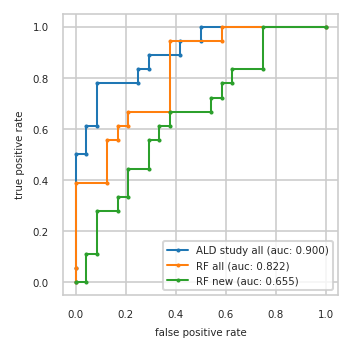

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.500  0.000 0.389  0.042 0.111
3          0.042 0.500  0.125 0.389  0.083 0.111
4          0.042 0.611  0.125 0.556  0.083 0.278
5          0.083 0.611  0.167 0.556  0.167 0.278
6          0.083 0.778  0.167 0.611  0.167 0.333
7          0.250 0.778  0.208 0.611  0.208 0.333
8          0.250 0.833  0.208 0.667  0.208 0.444
9          0.292 0.833  0.375 0.667  0.292 0.444
10         0.292 0.889  0.375 0.944  0.292 0.556
11         0.417 0.889  0.583 0.944  0.333 0.556
12         0.417 0.944  0.583 1.000  0.333 0.611
13         0.500 0.944  1.000 1.000  0.375 0.611
14         0.500 1.000    NaN   NaN  0.375 0.667
15         1.000 1.000    NaN   NaN  0.542 0.667
16           NaN   NaN    NaN   NaN  0.542 0.722
17           NaN   NaN    NaN   NaN  0.583 0.722
18           NaN   NaN    NaN   NaN  0.583 0.778
19           NaN   NaN    NaN   NaN  0.625 0.778
20           NaN   NaN    NaN   NaN  0.625 0.833
21           NaN   NaN    NaN   NaN  0.750 0.833
22           NaN   NaN    NaN   NaN  0.750 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q9NRN5,P07093-2;P07093-3,A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3
2,P09486,Q96MK3,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
3,Q86V85,P31150,P31321
4,P61981,P10636-2;P10636-6,A0A075B7B8
5,P10636-2;P10636-6,P04075,P51688
6,P14174,C9JF17;P05090,E9PK25;G3V1A4;P23528
7,Q9Y2T3;Q9Y2T3-3,P61981,Q96GD0
8,A0A0C4DGY8;D6RA00;Q9UHY7,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


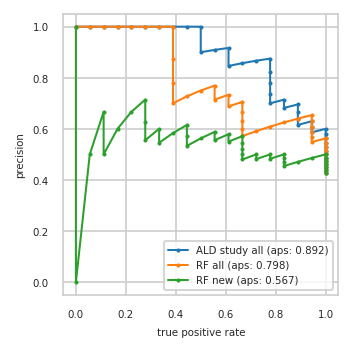

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.615 0.889     0.654 0.944     0.500 0.722
17         0.640 0.889     0.640 0.889     0.480 0.667
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.571 0.667
22         0.700 0.778     0.600 0.667     0.550 0.611
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.875 0.778     0.688 0.611     0.562 0.500
27         0.867 0.722     0.733 0.611     0.533 0.444
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.846 0.611     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.700 0.389     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


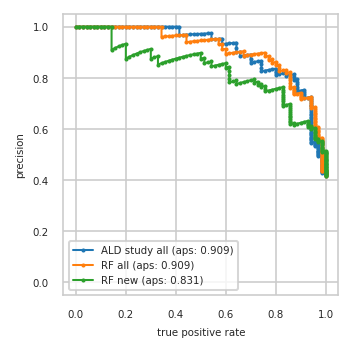

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


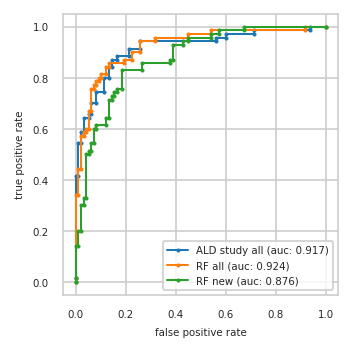

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}